In [2]:
import pandas as pd
import numpy as np
from aco import ACO, Graph
from plot import plot
import datetime
import pickle
import argparse
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim
import xgboost as xgb
import pprint
import matplotlib.pyplot as plt

In [4]:
from zipfile import ZipFile
with ZipFile('basic_analysis.zip', 'r') as zip_ref:
    zip_ref.extractall('basic_analysis')

In [5]:
filename = "/content/xgb_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))
geolocator = Nominatim(user_agent="aco-application")

In [6]:
def time_cost_between_points(loc1, loc2, passenger_count, store_and_fwd_flag=0):
    """
    Calculate the time (in minutes) between two points
    using the trained XGB model
    """
    # Hardcode the date to get consistent calculations
    date_list = [27, 5, 2016]  # May 27, 2016

    year = int(date_list[2])
    month = int(date_list[1])
    day = int(date_list[0])

    my_date = datetime.date(year, month, day)

    model_data = {'passenger_count': passenger_count,
                  'pickup_longitude': loc1['x'],
                  'pickup_latitude': loc1['y'],
                  'dropoff_longitude': loc2['x'],
                  'dropoff_latitude': loc2['y'],
                  'store_and_fwd_flag': bool(store_and_fwd_flag),
                  'pickup_month': my_date.month,
                  'pickup_day': my_date.day,
                  'pickup_weekday': my_date.weekday(),
                  'pickup_hour': 23,
                  'pickup_minute': 10,
                  'latitude_difference': loc2['y'] - loc1['y'],
                  'longitude_difference': loc2['x'] - loc1['x'],
                  'trip_distance': trip_distance_cost(loc1, loc2)
                  }

    df = pd.DataFrame([model_data], columns=model_data.keys())
    pred = np.exp(loaded_model.predict(xgb.DMatrix(df))) - 1
    return pred[0]

In [7]:
def trip_distance_cost(loc1, loc2):
    """
    Calculate the manhattan distance between two points using
    polar coordinates in taxicab geometry https://en.wikipedia.org/wiki/Taxicab_geometry
    """
    return 0.621371 * 6371 * (
        abs(2 * np.arctan2(np.sqrt(np.square(
            np.sin((abs(loc2['y'] - loc1['y']) * np.pi / 180) / 2))),
            np.sqrt(1-(np.square(np.sin((abs(loc2['y'] - loc1['y']) * np.pi / 180) / 2)))))) +
        abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(loc2['x'] - loc1['x']) * np.pi / 180) / 2))),
                           np.sqrt(1-(np.square(np.sin((abs(loc2['x'] - loc1['x']) * np.pi / 180) / 2)))))))

In [12]:
# Read in command line arguments
parser = argparse.ArgumentParser()
parser.add_argument("loc_count", type=int, nargs='?', default=15,
                    help="number of locations (default is 15)")
parser.add_argument("ant_count", type=int, nargs='?', default=10,
                    help="number of ants to use (default is 10)")
parser.add_argument("g", type=int, nargs='?', default=100,
                    help="number of generations (default is 100)")
parser.add_argument("alpha", type=float, nargs='?', default=1.0,
                    help="relative importance of pheromone (default is 1.0)")
parser.add_argument("beta", type=float, nargs='?', default=10.0,
                    help="relative importance of heuristic information (default is 10.0)")
parser.add_argument("rho", type=float, nargs='?', default=0.5,
                    help="pheromone residual coefficient (default is 0.5)")
parser.add_argument("q", type=float, nargs='?', default=10.0,
                    help="pheromone intensity (default is 10.0)")
parser.add_argument("--verbose", action="store_true",
                    help="print out each generation cost and best path")
# Pass an empty list to parse_args() to prevent it from trying to parse
# command line arguments passed to the Colab kernel.
args = parser.parse_args([])

locations = []
points = []

In [13]:
# Read in the user specified number of lines from the test data
df = pd.read_csv("/content/basic_analysis/nyc-taxi-trip-duration/test.zip")[:args.loc_count]
for index, row in df.iterrows():
    locations.append({
        'index': index,
        'x': row['pickup_longitude'],
        'y': row['pickup_latitude']
    })
    points.append((row['pickup_longitude'], row['pickup_latitude']))


In [14]:
# Build complete cost matrix based on time between points
cost_matrix = []
rank = len(locations)
for i in range(rank):
    row = []
    for j in range(rank):
        row.append(time_cost_between_points(
            locations[i], locations[j],
            1, 0))
    cost_matrix.append(row)

In [15]:
# Pass in user arguments
aco = ACO(ant_count=args.ant_count, generations=args.g, alpha=args.alpha,
          beta=args.beta, rho=args.rho, q=args.q, strategy=2)


In [16]:
# Build graph with cost matrix and number of points
graph = Graph(cost_matrix, rank)
# Get results from ant colony, specify whether verbose output
best_path, cost, avg_costs, best_costs = aco.solve(graph, args.verbose)

In [17]:
# Print out and plot final solution
print('Final cost: {} minutes, path: {}'.format(cost, best_path))

# Output the mean and standard deviantion of min costs per generation
print("Min cost mean:", np.mean(best_costs))
print("Min cost standard deviation:", np.std(best_costs))

Final cost: 135.90650939941406 minutes, path: [3, 4, 11, 5, 9, 14, 2, 8, 0, 13, 6, 7, 1, 10, 12]
Min cost mean: 139.0444
Min cost standard deviation: 1.7021289


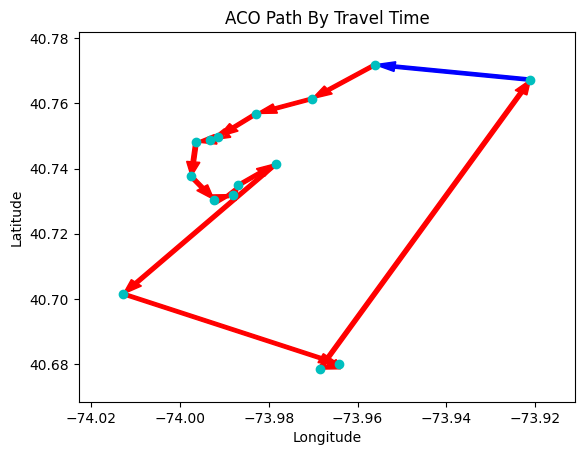

In [18]:
# Print out final addresses in solution
if args.verbose:
    print("Final path addresses:")
    try:
        addresses = []
        for p in best_path:
            addresses.append(geolocator.reverse(
                f"{points[p][1]}, {points[p][0]}").address)
        pprint.pprint(addresses)
    except GeocoderTimedOut as e:
        print(f"Error: geocode failed with message {e}")

plot(points, best_path)

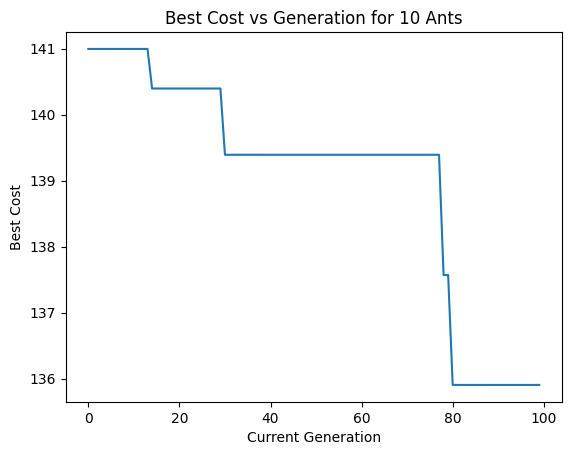

In [19]:
x_values = [i for i in range(args.g)]
plt.title("Best Cost vs Generation for " + str(args.ant_count) + " Ants")
plt.ylabel("Best Cost")
plt.xlabel("Current Generation")
plt.plot(x_values, best_costs)
plt.show()

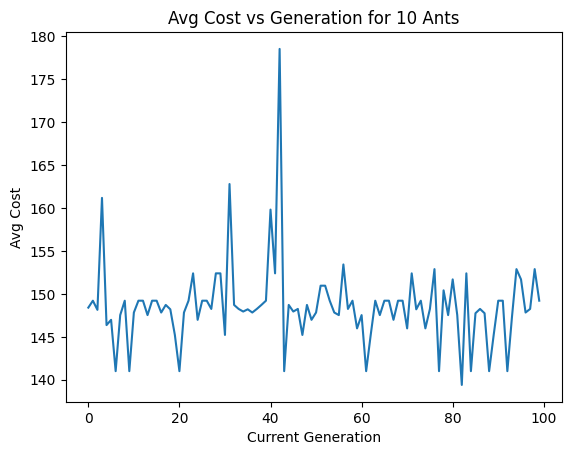

In [20]:
x_values = [i for i in range(args.g)]
plt.title("Avg Cost vs Generation for " + str(args.ant_count) + " Ants")
plt.ylabel("Avg Cost")
plt.xlabel("Current Generation")
plt.plot(x_values, avg_costs)
plt.show()